# TB Dataset Interpretation Notebook

In [1]:
library(Seurat)
library(dplyr)
library(Matrix)
library(ggplot2)
library(ggpubr)
library(xtable)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Identify and Extract Expression for Top Variable Genes

In [2]:
# Imports normalized gene expression data
gene_expr = readRDS('/data/srlab1/anathan/TBRU/data/analysis/exprs_norm_01.12.rds')

In [ ]:
# Use Seruat to efficiently compute variable genes
seurat<-CreateSeuratObject(counts = gene_expr, 
                           min.cells = 0, min.features = 0, # Maintain QC from previous study
                           project = "TBRU")

In [ ]:
n_var_genes = 5000

In [ ]:
seurat <- FindVariableFeatures(seurat, selection.method = "vst", nfeatures = n_var_genes)

In [ ]:
var_genes <- head(VariableFeatures(seurat), n_var_genes)

In [ ]:
write.table(var_genes, "/data/srlab/lrumker/MCSC_Project/TBRU_dset_extras/TBRU_var_genes.txt", sep = "\t")

## Load Data

In [3]:
### Include only cells retained by CNA
refine_cells <- function(expr_mat, input_res){
    loc_cells = match(input_res$cell_id[which(input_res$keptcells=="True")], colnames(expr_mat))
    input_res = input_res[which(input_res$keptcells=="True"),]
    expr_mat = expr_mat[,loc_cells]
    
    # Confirm cell order matches
    if(sum(input_res$cell_id==colnames(expr_mat))==dim(input_res)[1]){
        return(list(expr_mat, input_res))
    }else{
      return(list(False, False))   
    }
}

In [4]:
### Compute per-gene correlations to information of interest (e.g. NAM PC loadings)
compute_corrs <- function(curr_res, expr_mat, corr_col_name){
    cna_scores = curr_res[corr_col_name]
    corrs = c()
    for(i in c(1:floor(nrow(expr_mat)/1000))){
        i_start = (1+1000*(i-1))
        i_end = (1000*i)
        new_corrs = cor(t(as.matrix(expr_mat[i_start:i_end,])), cna_scores)
        corrs = c(corrs,new_corrs)
    }
    if(i_end !=nrow(expr_mat)){
        i = i+1
        i_start = (1+1000*(i-1))
        i_end = nrow(expr_mat)
        new_corrs = cor(t(as.matrix(expr_mat[i_start:i_end,])), cna_scores)
        corrs = c(corrs,new_corrs)
    }
    names(corrs) = rownames(expr_mat)
    return(corrs)
}

In [5]:
load_data <-function(res_filename, expr_filename, corr_col_name){
    res = read.csv(res_filename)
    expr_mat = readRDS(expr_filename)
    if(length(grep("/exprs_norm",expr_filename))==1){
        var_genes = read.csv("/data/srlab/lrumker/MCSC_Project/TBRU_dset_extras/TBRU_var_genes.txt",sep = "\t")
        var_genes = var_genes$x
        expr_mat = expr_mat[match(var_genes, rownames(expr_mat)),]
    }
    return(refine_cells(expr_mat, res))
}

### GSEA

In [6]:
library(fgsea)
library(GSA)

In [7]:
### Parameters and function for loading gene sets
GeneSet_SizeBound_Upper = 500 # Maximum gene set size considered
GeneSet_SizeBound_Lower = 0 # Minimum gene set size considered

# File names
geneset_files = c("/data/srlab/lrumker/MSigDB_Sets/c7.all.v7.0.symbols.gmt.txt", #Immune
                  "/data/srlab/lrumker/MSigDB_Sets/h.all.v7.0.symbols.gmt.txt", #Hallmark
                  "/data/srlab/lrumker/MSigDB_Sets/c2.all.v7.0.symbols.gmt.txt", #Cannonical
                 "/data/srlab/lrumker/MSigDB_Sets/c1.all.v7.4.symbols.gmt.txt") #Chromosomal

parseGeneSetGMT <-function(filepath, known_genes, sizeBound_Upper, sizeBound_Lower){
  Gene_Sets_DB = GSA.read.gmt(filepath)
  GeneSet_sizes = sapply(Gene_Sets_DB$genesets,length)
  recognized_genes = matrix(NA, nrow=length(GeneSet_sizes), ncol = max(GeneSet_sizes))
  for(i in c(1:length(GeneSet_sizes))){
    recognized_genes[i,c(1:GeneSet_sizes[i])] = Gene_Sets_DB$genesets[[i]]
  }
  recognized_genes = matrix(is.element(recognized_genes, known_genes), ncol = ncol(recognized_genes))
  GeneSet_sizes = apply(recognized_genes, 1, sum)
  retain_GeneSet = (GeneSet_sizes>=sizeBound_Lower)&(GeneSet_sizes<=sizeBound_Upper)
  Gene_Sets_DB$genesets = Gene_Sets_DB$genesets[retain_GeneSet]
  Gene_Sets_DB$geneset.names = Gene_Sets_DB$geneset.names[retain_GeneSet]
  Gene_Sets_DB$geneset.descriptions = Gene_Sets_DB$geneset.descriptions[retain_GeneSet]
  Gene_Sets_DB$geneset.sizes = GeneSet_sizes[retain_GeneSet]
  return(Gene_Sets_DB)
}

In [8]:
run_GSEA_byFile <-function(genesettype, rankList, filter_output=TRUE, 
                           GeneSet_SizeBound_Upper = 500, GeneSet_SizeBound_Lower = 0){
    # Genesettype takes string values "immune", "canonical", "immune", and 'chromosomal'
    # rankList must be named with gene labels per value
    if(genesettype=="canonical"){
        i_file = 3
    }else if(genesettype=="hallmark"){
        i_file = 2
    }else if(genesettype=="immune"){
        i_file = 1
    }else if(genesettype=="chromosomal"){
        i_file = 4
    }else{
        print("Geneset file label not recognized.")
        return
    }
    Gene_Sets_DB = parseGeneSetGMT(geneset_files[i_file], names(rankList), 
                                   GeneSet_SizeBound_Upper, GeneSet_SizeBound_Lower)
    input_genesets = Gene_Sets_DB$genesets
    names(input_genesets) = Gene_Sets_DB$geneset.names

    FGSEA_output = fgsea(input_genesets, rankList, nperm=10000, 
                             minSize = 15, maxSize = 500, nproc = 0,
                             gseaParam = 1, BPPARAM = NULL)
    
    if(filter_output){
        FGSEA_output = FGSEA_output[order(FGSEA_output$padj),]
        FGSEA_output = FGSEA_output[which(FGSEA_output$padj<0.05),c(1,3,4)]
    }
    return(FGSEA_output)
}

### Differentially-Expressed Genes

In [64]:
library(presto)

characteristic_expr <-function(expr_mat, categories){
    wilcox_res <- wilcoxauc(expr_mat, categories)
    wilcox_res = wilcox_res[which(wilcox_res$padj<0.05),]
    wilcox_res = wilcox_res[which(wilcox_res$group=="True"),]
    wilcox_res_pos = wilcox_res[which(wilcox_res$logFC>0),]
    wilcox_res_neg = wilcox_res[which(wilcox_res$logFC<0),]
    return(wilcox_res_pos[order(wilcox_res_pos$logFC, decreasing = TRUE),c(1,2,3,4,6,8)])
}

ERROR: Error in library(presto): there is no package called ‘presto’


### Export Association Table for Genes and Proteins

In [9]:
table_destination = '/data/srlab/lrumker/MCSC_Project/cna-display/_tables/'

report_assoc <- function(prot_mat, expr_mat,prot_names, gene_names, ncorrs, 
                         table_destination, export_filename){
    corrs = c()
    pvals = c()
    print("Testing proteins")
    for(sel_prot in prot_names){
        my_expr = prot_mat[match(sel_prot, rownames(prot_mat)),]
        my_data = data.frame(ncorrs, my_expr)
        colnames(my_data) = c("corrs", "expr")
        new_summary = summary(lm(corrs ~ expr, data = my_data))
        new_p = new_summary$coefficients[2,4]
        new_corr = cor(my_expr, ncorrs)
        corrs = c(corrs, new_corr)
        pvals = c(pvals, new_p)
    }
    print("Testing genes")
    for(sel_gene in gene_names){
        my_expr = expr_mat[match(sel_gene, rownames(expr_mat)),]
        my_data = data.frame(ncorrs, my_expr)
        colnames(my_data) = c("corrs", "expr")
        new_summary = summary(lm(corrs ~ expr, data = my_data))
        new_p = new_summary$coefficients[2,4]
        new_corr = cor(my_expr, ncorrs)
        corrs = c(corrs, new_corr)
        pvals = c(pvals, new_p)
    }
    df = data.frame("Name"= c(prot_names, gene_names), 
                        "Type"= c(rep("Protein", length(prot_names)),
                                               rep("Gene", length(gene_names))),
                        "Correlation"=corrs, "P-value"=pvals)
    df$P.value[which(df$P.value<0.0000000001)] = "<1e-10"
    df$Correlation = round(df$Correlation,3)
    to_export<-xtable(df)
    print.xtable(to_export, type="latex", file=paste0(table_destination,export_filename), 
                 floating=FALSE,latex.environments=NULL, include.rownames=FALSE)
    return(df)
}

# Unsupervised Analysis:  Interpretation of NAM-PCs

## NAM-PCs Corresponding to Sex from mRNA without Harmony batch correction

Higher loadings on PC2 and PC4 are more associated with 'male' designation

### NAM-PC2

In [10]:
# Import neighborhood loadings per NAM PC, for non-harmonized mRNA data
nam_pcs = read.csv("~/unsupervised_interpretation.csv")

In [11]:
# Import gene expression data, consider only top 5000 variable genes
expr_mat = readRDS('/data/srlab1/anathan/TBRU/data/analysis/exprs_norm_01.12.rds')
var_genes = read.csv("/data/srlab/lrumker/MCSC_Project/TBRU_dset_extras/TBRU_var_genes.txt",sep = "\t")
var_genes = var_genes$x
expr_mat = expr_mat[match(var_genes, rownames(expr_mat)),]

In [12]:
# Consider only retained cells (others filtered out by CNA due to strong batch associations)
expr_mat = expr_mat[,match(nam_pcs$cell_id, colnames(expr_mat))]

In [13]:
# Gene correlations
corrs_namPC2 = compute_corrs(nam_pcs, expr_mat, "PC2")

Warning message in cor(t(as.matrix(expr_mat[i_start:i_end, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[i_start:i_end, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[i_start:i_end, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[i_start:i_end, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[i_start:i_end, ])), cna_scores):
“the standard deviation is zero”


In [14]:
# Most anticorrelated (most "female"-like)
# RPS4X is on X chromosome https://genome.cshlp.org/content/8/5/509/F2.large.jpg
corrs_namPC2[order(corrs_namPC2)][1:10]

LTB       JUNB        FOS      RPS4X      SOCS3      RPS3A      RPS12 
-0.4457583 -0.4441059 -0.3423881 -0.3134598 -0.3098587 -0.2945748 -0.2808232 
     RPS13      RPL30       RPS5 
-0.2795071 -0.2709139 -0.2672875

In [15]:
# Most correlated (most "male"-like)
corrs_namPC2[order(-corrs_namPC2)][1:10]

NKG7      GZMH    FGFBP2      CST7      GZMA      GNLY      CCL5      ZEB2 
0.5473079 0.5091626 0.4443004 0.4408351 0.4391795 0.4235900 0.4174734 0.4008254 
     PRF1     EFHD2 
0.4000406 0.3802505

In [16]:
FGSEA_output = run_GSEA_byFile("canonical", corrs_namPC2)

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nperm = 10000, minSize = 15, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.44% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


In [17]:
FGSEA_output[c(grep("PID", FGSEA_output$pathway),
              grep("REACTOME", FGSEA_output$pathway)),]

pathway,padj,ES
<chr>,<dbl>,<dbl>
REACTOME_IMMUNOREGULATORY_INTERACTIONS_BETWEEN_A_LYMPHOID_AND_A_NON_LYMPHOID_CELL,0.02420225,0.7974857
REACTOME_ADAPTIVE_IMMUNE_SYSTEM,0.02420225,0.6955192
REACTOME_TRANSLATION,0.03747582,-0.9093982
REACTOME_SRP_DEPENDENT_COTRANSLATIONAL_PROTEIN_TARGETING_TO_MEMBRANE,0.03747582,-0.9418037
REACTOME_HEMOSTASIS,0.03747582,0.6612266
REACTOME_COMPLEMENT_CASCADE,0.03747582,0.8590857
REACTOME_PLATELET_ACTIVATION_SIGNALING_AND_AGGREGATION,0.03747582,0.7221948
REACTOME_INITIAL_TRIGGERING_OF_COMPLEMENT,0.03747582,0.9069606
REACTOME_SELENOAMINO_ACID_METABOLISM,0.03747582,-0.9391923


In [23]:
# Difference in position along NAM-PC2 per-cluster between male and female participants
is_Treg = which(nam_pcs$leiden2==6)
mask_Treg = rep(FALSE, nrow(nam_pcs))
mask_Treg[is_Treg] = TRUE
is_CD8_activated = which(nam_pcs$leiden2==29)
is_CD4_activated = which(nam_pcs$leiden2==21)
mask_activated = rep(FALSE, nrow(nam_pcs))
mask_activated[is_CD8_activated] = TRUE
mask_activated[is_CD4_activated] = TRUE

mask_CD4 = rep(FALSE, nrow(nam_pcs))
mask_Treg[is_Treg] = TRUE

In [24]:
mask_female = nam_pcs$Sex_M == 'False'
mask_male = nam_pcs$Sex_M == 'True'

In [28]:
sum(mask_female*mask_Treg)/sum(mask_female)

[1] 0.05402731

In [27]:
sum(mask_male*mask_Treg)/sum(mask_male)

[1] 0.04883942

In [62]:
# More male --> fewer activated cells
# we would expect negative correlation
cor(mask_activated, nam_pcs$PC2)

[1] 0.09623465

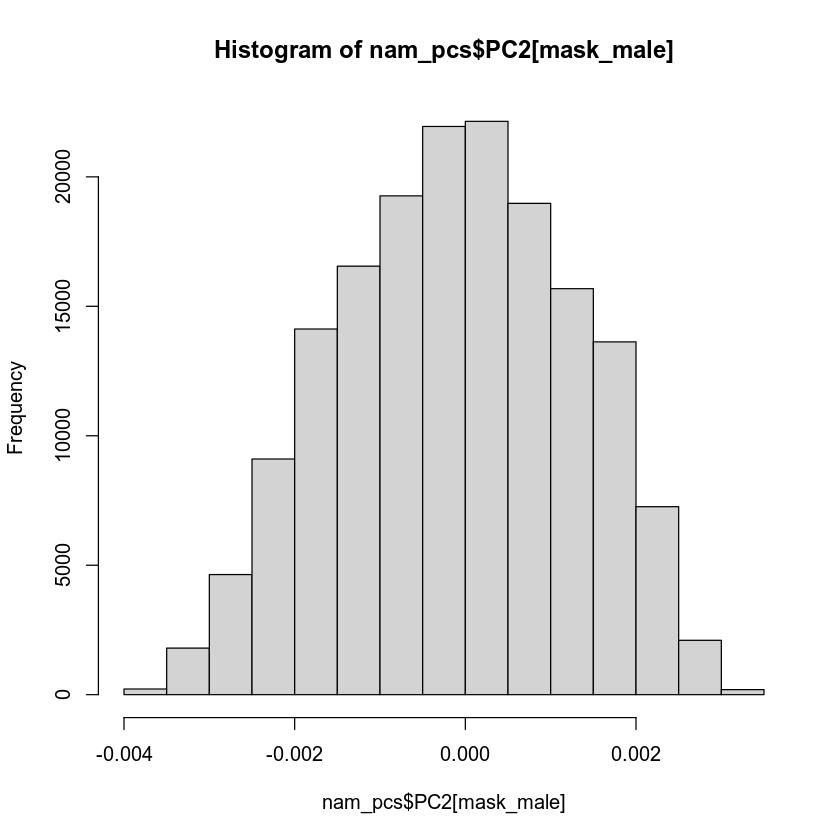

In [75]:
hist(nam_pcs$PC2[mask_male])

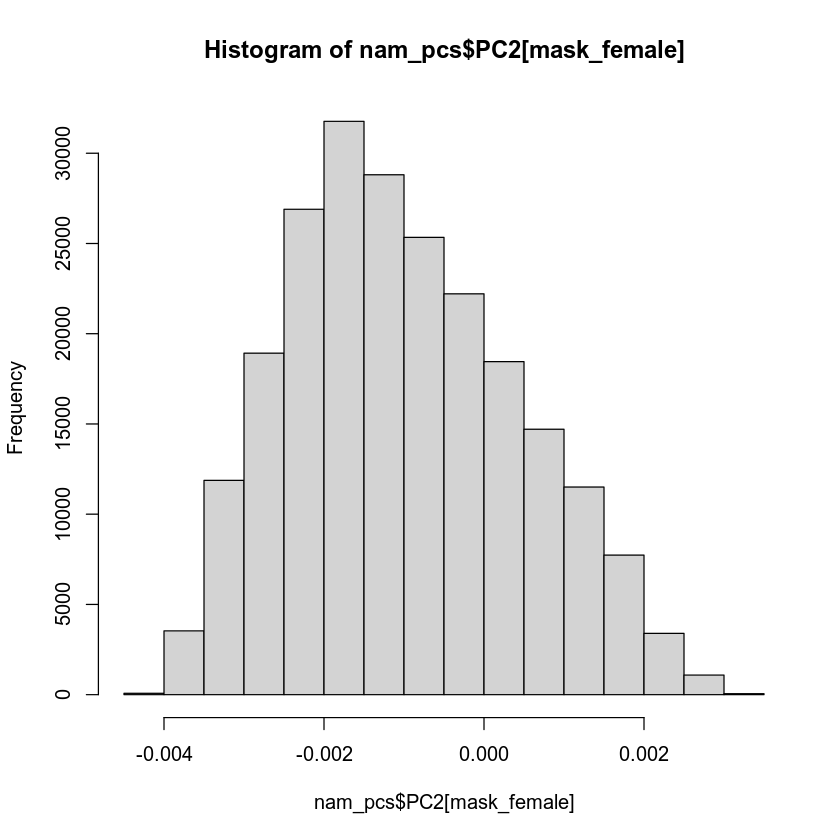

In [76]:
hist(nam_pcs$PC2[mask_female])

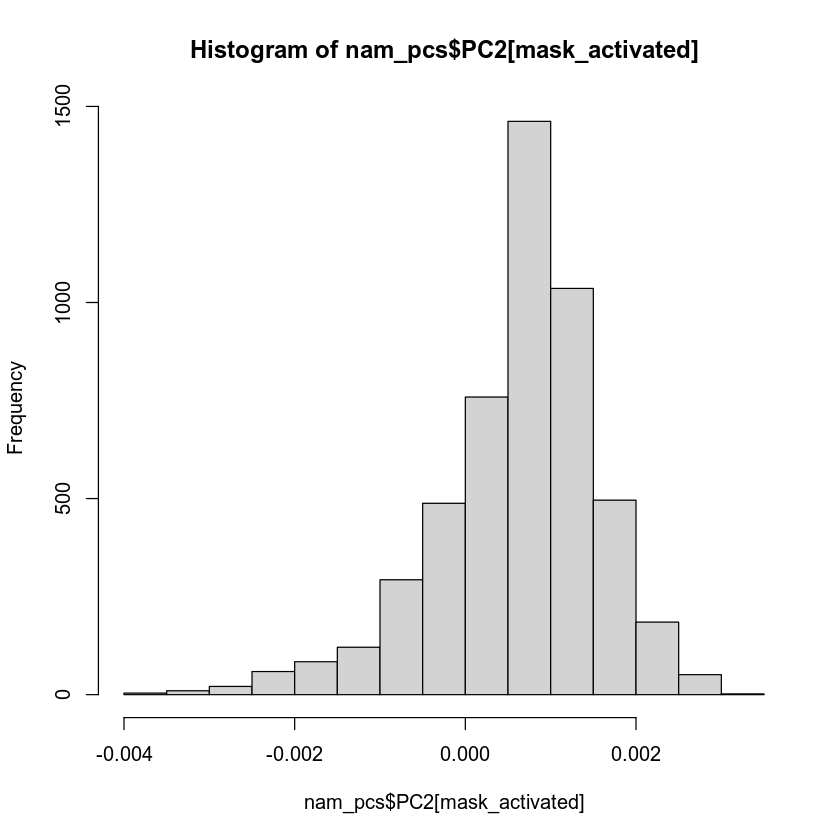

In [74]:
hist(nam_pcs$PC2[mask_activated])

In [63]:
# More male --> more Tregs
# we would expect positive correlation
cor(mask_Treg, nam_pcs$PC2)

[1] -0.07176076

In [77]:
cor(expr_mat[match('IFNG', rownames(expr_mat)),], nam_pcs$PC2)

[1] 0.1405733

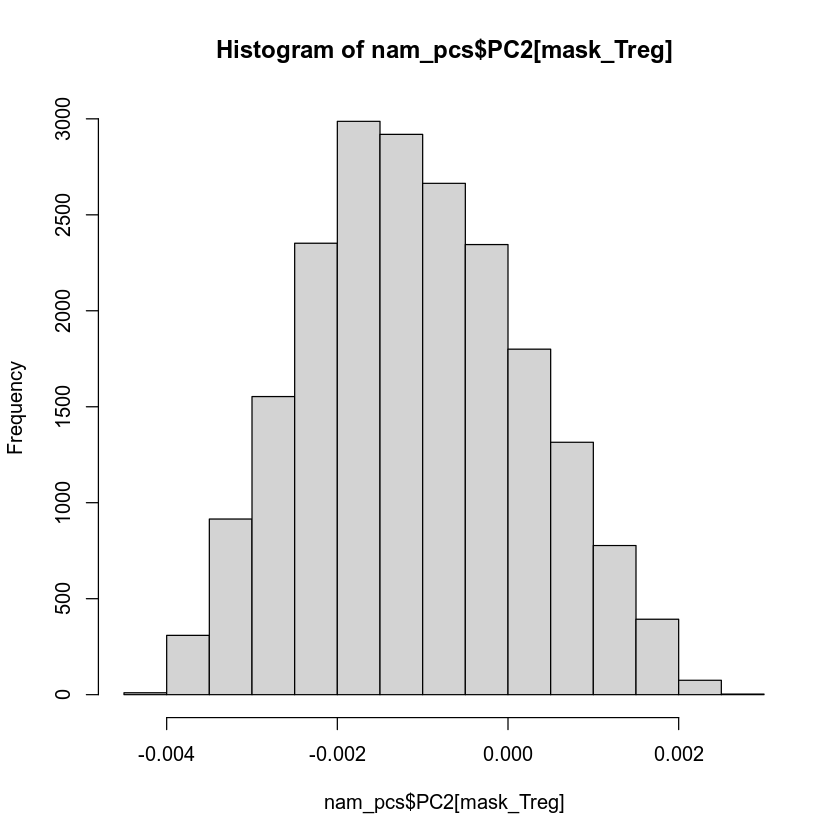

In [73]:
hist(nam_pcs$PC2[mask_Treg])

In [15]:
prot_mat = readRDS('/data/srlab1/anathan/TBRU/data/analysis/adt_exprs_norm_01.12.rds')

In [16]:
# Consider only retained cells (others filtered out by CNA due to strong batch associations)
prot_mat = prot_mat[,match(nam_pcs$cell_id, colnames(prot_mat))]

In [17]:
prot_corrs_namPC2 = cor(t(as.matrix(prot_mat)), nam_pcs$PC2)

In [18]:
prot_corrs_namPC2[order(prot_corrs_namPC2),]

CD127/IL-7R       CD28.1        CD4.1         CD26       CD27.1   CD194/CCR4 
-0.344531487 -0.327103904 -0.271099497 -0.268913643 -0.262069319 -0.130878089 
       CD62L   CD196/CCR6        CD272  CD48/SLAMF2        CD5.1   CD197/CCR7 
-0.099571086 -0.098838720 -0.091194559 -0.071010615 -0.055708304 -0.045911736 
 CD183/CXCR3         CD25  CD294/CRTH2     MouseIgG        CD161       CD69.1 
-0.040761712 -0.013554918 -0.004949376  0.015212735  0.028919601  0.039159844 
  CD278/ICOS     CD95/Fas         CD29        TCRab      TIGIT.1       CD38.1 
 0.058405205  0.080484413  0.081702464  0.137651785  0.148575019  0.170922405 
      CD45RO          CD3   CD279/PD-1       HLA-DR   CD195/CCR5         CD8a 
 0.171445869  0.194882648  0.250093556  0.286168616  0.323968552  0.331344355 
   CD244/2B4 
 0.468935264

In [19]:
namPC2_report = report_assoc(prot_mat, expr_mat,
                             prot_names = c("CD4.1", "CD8a"),
                             gene_names = c(),
                             nam_pcs$PC2,
                            table_destination, "supptable.tbru.PC2.tex") 

[1] "Testing proteins"
[1] "Testing genes"


In [20]:
namPC2_report

Name,Type,Correlation,P.value
<chr>,<chr>,<dbl>,<chr>
CD4.1,Protein,-0.271,<1e-10
CD8a,Protein,0.331,<1e-10


### NAM-PC4 ~ Sex Chromosome Genes

In [88]:
corrs_namPC4 = compute_corrs(nam_pcs, expr_mat, "PC4")

Warning message in cor(t(as.matrix(expr_mat[i_start:i_end, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[i_start:i_end, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[i_start:i_end, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[i_start:i_end, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[i_start:i_end, ])), cna_scores):
“the standard deviation is zero”


In [100]:
namPC4_chrXY_report = report_assoc(prot_mat, expr_mat,
                             prot_names = c(),
                             gene_names = c("XIST", "RPS4Y1", "DDX3Y", "UTY", "TTTY15", "KDM5D", "USP9Y"),
                             nam_pcs$PC4,
                            table_destination, "supptable.tbru.PC4.tex") 

[1] "Testing proteins"
[1] "Testing genes"


In [101]:
namPC4_chrXY_report 

Name,Type,Correlation,P.value
<fct>,<fct>,<dbl>,<chr>
XIST,Gene,-0.408,<1e-10
RPS4Y1,Gene,0.582,<1e-10
DDX3Y,Gene,0.349,<1e-10
UTY,Gene,0.301,<1e-10
TTTY15,Gene,0.257,<1e-10
KDM5D,Gene,0.176,<1e-10
USP9Y,Gene,0.157,<1e-10


In [95]:
# Most anticorrelated (most "female"-like)
corrs_namPC4[order(corrs_namPC4)][1:10]

XIST       CCL5       GZMA       GZMK       LYAR       HOPX      ANXA1 
-0.4081395 -0.2392425 -0.2122025 -0.1872422 -0.1857520 -0.1808897 -0.1493407 
      HCST      DDX3X      ITGA4 
-0.1425302 -0.1412150 -0.1393180

In [97]:
# Most correlated (most "female"-like)
corrs_namPC4[order(-corrs_namPC4)][1:10]

RPS4Y1     DDX3Y       UTY    TTTY15     KDM5D     USP9Y     RPLP1      SELL 
0.5824731 0.3488346 0.3005808 0.2570993 0.1762696 0.1569847 0.1497203 0.1233270 
    TSHZ2     FOXP3 
0.1015425 0.0920509

### NAM-PCs Corresponding to Innateness

In [11]:
# Imports neighborhood loadings per NAM PC, for harmonized CCA data
nam_pcs = read.csv("/data/srlab/lrumker/MCSC_Project/TBRU_dset_extras/TBRU_cna_NAM_PCs.txt")

In [12]:
# Import gene expression data, consider only top 5000 variable genes
expr_mat = readRDS('/data/srlab1/anathan/TBRU/data/analysis/exprs_norm_01.12.rds')
var_genes = read.csv("/data/srlab/lrumker/MCSC_Project/TBRU_dset_extras/TBRU_var_genes.txt",sep = "\t")
var_genes = var_genes$x
expr_mat = expr_mat[match(var_genes, rownames(expr_mat)),]

# Consider only retained cells (others filtered out by CNA due to strong batch associations)
expr_mat = expr_mat[,match(nam_pcs$cell_id, colnames(expr_mat))]

In [13]:
corrs = compute_corrs(nam_pcs, expr_mat, "PC1")

Warning message in cor(t(as.matrix(expr_mat[i_start:i_end, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[i_start:i_end, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[i_start:i_end, ])), cna_scores):
“the standard deviation is zero”


In [14]:
corrs[order(corrs, decreasing = TRUE)][1:10]

LTB       MAL      TCF7      JUNB      LDHB      IL7R     SOCS3     RCAN3 
0.5451923 0.3487039 0.3371418 0.3153410 0.2933276 0.2896569 0.2743541 0.2714428 
     SELL      PASK 
0.2397074 0.2310192

In [24]:
corrs[order(-corrs, decreasing = TRUE)][1:10]

NKG7       GZMH       CCL5       GZMA     FGFBP2       GNLY       CST7 
-0.8101558 -0.7608426 -0.6977730 -0.6727560 -0.6700009 -0.6664520 -0.6339334 
      ZEB2      EFHD2       PRF1 
-0.5613905 -0.5432757 -0.5268744

In [28]:
innateness_report = report_assoc(prot_mat, expr_mat,
                             prot_names = c("CD62L"), 
                             gene_names = c("SELL", "NKG7", "GZMH", "CCL5", "GZMA", "GNLY"), 
                             nam_pcs$PC1, 
                             table_destination, "supptable.tbru.innateness.tex") 

[1] "Testing proteins"
[1] "Testing genes"


In [29]:
innateness_report

Name,Type,Correlation,P.value
<fct>,<fct>,<dbl>,<chr>
CD62L,Protein,0.152,<1e-10
SELL,Gene,0.240,<1e-10
NKG7,Gene,-0.810,<1e-10
GZMH,Gene,-0.761,<1e-10
CCL5,Gene,-0.698,<1e-10
GZMA,Gene,-0.673,<1e-10
GNLY,Gene,-0.666,<1e-10


# Supervised Analysis Interpretation

### Ancestry Signal Interpretation

In [14]:
list_out = load_data("/data/srlab/lrumker/MCSC_Project/mcsc_scratch/tbru_cna_Ancestry_res.txt",
                    '/data/srlab1/anathan/TBRU/data/analysis/exprs_norm_01.12.rds')
expr_mat = list_out[[1]]
curr_res = list_out[[2]]

In [15]:
list_out = load_data("/data/srlab/lrumker/MCSC_Project/mcsc_scratch/tbru_cna_Ancestry_res.txt",
                    '/data/srlab1/anathan/TBRU/data/analysis/adt_exprs_norm_01.12.rds')
prot_mat = list_out[[1]]
curr_res = list_out[[2]]

In [16]:
corrs = compute_corrs(curr_res, expr_mat, "ncorrs")

Warning message in cor(t(as.matrix(expr_mat[i_start:i_end, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[i_start:i_end, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[i_start:i_end, ])), cna_scores):
“the standard deviation is zero”


In [195]:
# Top most correlated genes
# round(corrs[order(-corrs)][1:15],2)

In [196]:
# Top most anticorrelated genes
# round(corrs[order(corrs)][1:15],2)

In [197]:
# Depleted cluster proteins
# characteristic_expr(prot_mat, curr_res$negcells)

In [198]:
# Expanded cluster proteins
# characteristic_expr(prot_mat, curr_res$poscells)

In [24]:
ancestry_report = report_assoc(prot_mat, expr_mat,
                             prot_names = c("CD8a", "CD194/CCR4", "CD62L", "CD244/2B4", "CD29","CD4.1"), 
                             gene_names = c("LTB","LDHB","SELL", "NKG7", "CCL5", "GZMH", "GZMA", "GNLY"), 
                             curr_res$ncorrs, 
                             table_destination, "supptable.tbru.ancestry.tex") 

[1] "Testing proteins"
[1] "Testing genes"


In [25]:
head(ancestry_report)

,Name,Type,Correlation,P.value
,<fct>,<fct>,<dbl>,<chr>
1,CD8a,Protein,0.042,<1e-10
2,CD194/CCR4,Protein,0.472,<1e-10
3,CD62L,Protein,0.245,<1e-10
4,CD244/2B4,Protein,-0.516,<1e-10
5,CD29,Protein,-0.210,<1e-10
6,CD4.1,Protein,-0.111,<1e-10


In [38]:
# Original clusters with highest representation
cluster_counts = table(curr_res[which(curr_res$poscells=="True"),]$cluster)
cluster_counts[order(cluster_counts, decreasing = TRUE)][1:10]
# 23: CD8+ central


  23   26    4    8    3   14   12   16   10    0 
5441  164  135  113   95   81   28   12    8    7 

In [39]:
# Original clusters with highest representation
cluster_counts = table(curr_res[which(curr_res$negcells=="True"),]$cluster)
cluster_counts[order(cluster_counts, decreasing = TRUE)][1:10]
# 7: CD4+ cytotoxic
# 18: CD4+ CD161+ cytotoxic
# 27: CD4+ CCR5+ cytotoxic


    7    18    27    11     2     9    19    24    10    22 
20560  8854  3896  2882   443   272   106    47    34    34 

### TB Progressor Signal Interpretation

In [30]:
list_out = load_data("/data/srlab/lrumker/MCSC_Project/mcsc_scratch/tbru_cna_TBres.txt",
                    '/data/srlab1/anathan/TBRU/data/analysis/exprs_norm_01.12.rds')
expr_mat = list_out[[1]]
curr_res = list_out[[2]]

In [31]:
list_out = load_data("/data/srlab/lrumker/MCSC_Project/mcsc_scratch/tbru_cna_TBres.txt",
                    '/data/srlab1/anathan/TBRU/data/analysis/adt_exprs_norm_01.12.rds')
prot_mat = list_out[[1]]
curr_res = list_out[[2]]

In [32]:
corrs = compute_corrs(curr_res, expr_mat, "ncorrs")

Warning message in cor(t(as.matrix(expr_mat[i_start:i_end, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[i_start:i_end, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[i_start:i_end, ])), cna_scores):
“the standard deviation is zero”


In [ ]:
# Top most correlated genes
#round(corrs[order(-corrs)][1:15],2)

In [ ]:
# Top most anticorrelated genes
#round(corrs[order(corrs)][1:15],2)

In [33]:
tb_report = report_assoc(prot_mat, expr_mat,
                             prot_names = c("CD26","CD196/CCR6","CD127/IL-7R", "CD244/2B4", "CD279/PD-1", "CD29"),
                             gene_names = c("LTB","AQP3","IL7R","KLRB1","CD27","MAL","GZMH","NKG7","FGFBP2","GNLY","ZEB2","CCL4"), 
                             curr_res$ncorrs,
                            table_destination, "supptable.tbru.tb_genesprots.tex") 

[1] "Testing proteins"
[1] "Testing genes"


In [35]:
tb_report

Name,Type,Correlation,P.value
<fct>,<fct>,<dbl>,<chr>
CD26,Protein,-0.385,<1e-10
CD196/CCR6,Protein,-0.409,<1e-10
CD127/IL-7R,Protein,-0.280,<1e-10
CD244/2B4,Protein,0.436,<1e-10
CD279/PD-1,Protein,0.203,<1e-10
CD29,Protein,0.140,<1e-10
LTB,Gene,-0.469,<1e-10
AQP3,Gene,-0.263,<1e-10
IL7R,Gene,-0.251,<1e-10


### Winter Signal Interpretation

In [51]:
list_out = load_data("/data/srlab/lrumker/MCSC_Project/mcsc_scratch/tbru_cna_Winter_res.txt",
                    '/data/srlab1/anathan/TBRU/data/analysis/exprs_norm_01.12.rds')
expr_mat = list_out[[1]]
curr_res = list_out[[2]]

In [52]:
list_out = load_data("/data/srlab/lrumker/MCSC_Project/mcsc_scratch/tbru_cna_Winter_res.txt",
                    '/data/srlab1/anathan/TBRU/data/analysis/adt_exprs_norm_01.12.rds')
prot_mat = list_out[[1]]
curr_res = list_out[[2]]

In [53]:
corrs = compute_corrs(curr_res, expr_mat, "ncorrs")

Warning message in cor(t(as.matrix(expr_mat[i_start:i_end, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[i_start:i_end, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[i_start:i_end, ])), cna_scores):
“the standard deviation is zero”


In [ ]:
# Top most correlated genes
# round(corrs[order(-corrs)][1:15],2)

In [ ]:
# Top most anticorrelated genes
# round(corrs[order(corrs)][1:15],2)

In [54]:
winter_report = report_assoc(prot_mat, expr_mat,
                             prot_names = c("CD183/CXCR3", "CD194/CCR4"),
                             gene_names = c("GATA3","KRT1","ANXA1","IL7R", "STAT1", "IFNG", "LIMS1","TIGIT", "CD27", "TBC1D4", "CTLA4"),
                             curr_res$ncorrs,
                            table_destination, "supptable.tbru.winter.tex") 

[1] "Testing proteins"
[1] "Testing genes"


In [55]:
head(winter_report)

,Name,Type,Correlation,P.value
,<fct>,<fct>,<dbl>,<chr>
1,CD183/CXCR3,Protein,-0.114,<1e-10
2,CD194/CCR4,Protein,0.278,<1e-10
3,GATA3,Gene,0.278,<1e-10
4,KRT1,Gene,0.263,<1e-10
5,ANXA1,Gene,0.263,<1e-10
6,IL7R,Gene,0.252,<1e-10


# Age Interpretation

### Age signal interpretation

In [36]:
list_out = load_data("/data/srlab/lrumker/MCSC_Project/mcsc_scratch/tbru_cna_Age_res.txt",
                    '/data/srlab1/anathan/TBRU/data/analysis/exprs_norm_01.12.rds')
expr_mat = list_out[[1]]
curr_res = list_out[[2]]

In [37]:
list_out = load_data("/data/srlab/lrumker/MCSC_Project/mcsc_scratch/tbru_cna_Age_res.txt",
                    '/data/srlab1/anathan/TBRU/data/analysis/adt_exprs_norm_01.12.rds')
prot_mat = list_out[[1]]
curr_res = list_out[[2]]

In [38]:
corrs = compute_corrs(curr_res, expr_mat, "ncorrs")

Warning message in cor(t(as.matrix(expr_mat[i_start:i_end, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[i_start:i_end, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[i_start:i_end, ])), cna_scores):
“the standard deviation is zero”


In [ ]:
# Top most correlated genes
# round(corrs[order(-corrs)][1:15],2)

In [ ]:
# Top most anticorrelated genes
# round(corrs[order(corrs)][1:15],2)

In [39]:
age_report = report_assoc(prot_mat, expr_mat,
                            gene_names = c("GZMH", "NKG7", "FGFBP2", "GNLY", "CST7", "GZMA", "CCL5", "CCL4",
                                          "KLRB1", "LTB",  "LDHB", "TCF7", "CCR6", "CD27"),
                             prot_names = c("CD8a","CD4.1","CD27.1","CD28.1"),
                             curr_res$ncorrs,
                            table_destination, "supptable.tbru.age.tex") 

[1] "Testing proteins"
[1] "Testing genes"


In [40]:
age_report

Name,Type,Correlation,P.value
<fct>,<fct>,<dbl>,<chr>
CD8a,Protein,0.248,<1e-10
CD4.1,Protein,-0.088,<1e-10
CD27.1,Protein,-0.354,<1e-10
CD28.1,Protein,-0.399,<1e-10
GZMH,Gene,0.551,<1e-10
NKG7,Gene,0.511,<1e-10
FGFBP2,Gene,0.482,<1e-10
GNLY,Gene,0.456,<1e-10
CST7,Gene,0.390,<1e-10


### Assign CD4+ and CD8+ Cell populations

In [540]:
CD4 = prot_mat[grep("CD4.1", rownames(prot_mat)),]
CD8 = prot_mat[grep("CD8a", rownames(prot_mat)),]
to_plot = data.frame("CD4" = CD4, "CD8" = CD8)

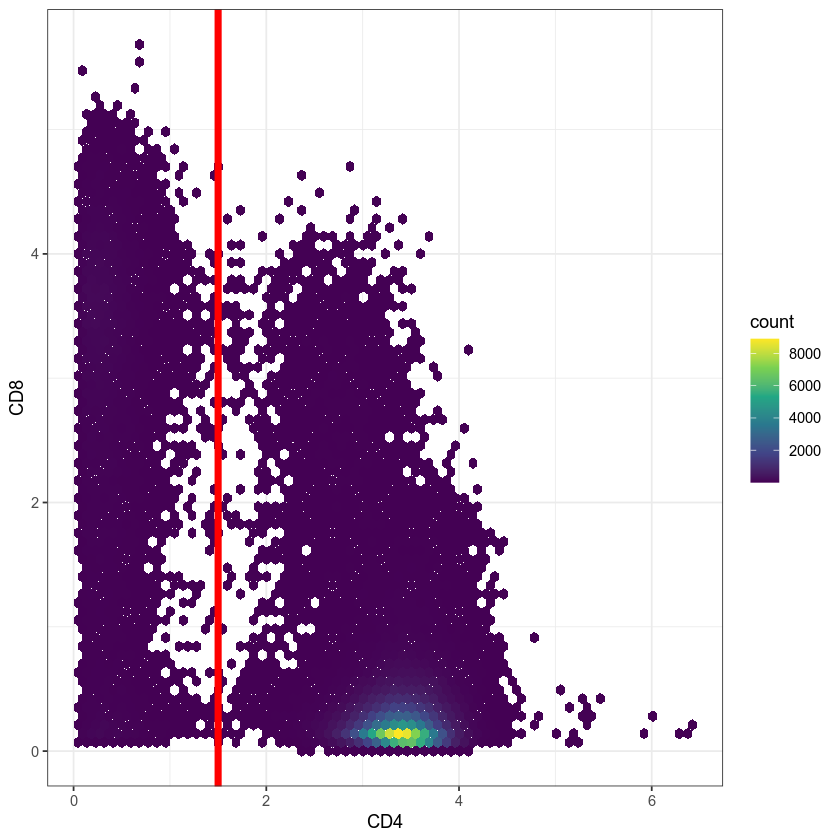

In [570]:
# Find low vs high CD4
some_expr = which((CD8>0)&(CD4>0))
ggplot(to_plot[some_expr,], aes(x=CD4, y=CD8) ) +
  geom_hex(bins = 70) +
  scale_fill_continuous(type = "viridis") +
  theme_bw()+
    geom_vline(xintercept=1.5, color = "red", size=2)

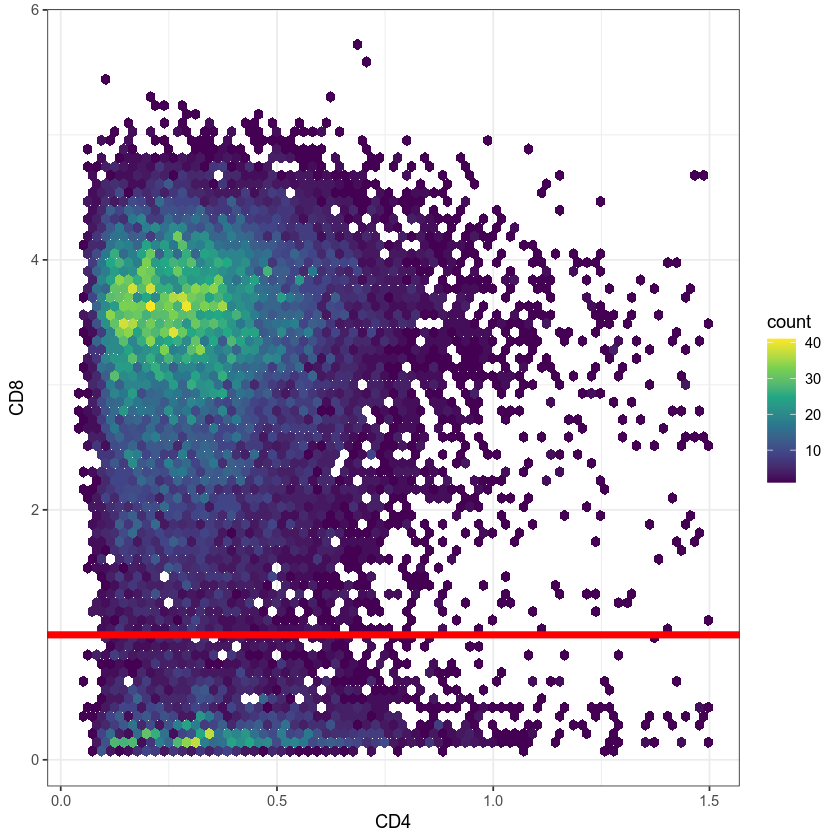

In [561]:
# Find low vs high CD8 gene expression
i_lowCD4 = which(((CD4<1.5)&(CD4>0))&(CD8>0))
ggplot(to_plot[i_lowCD4,], aes(x=CD4, y=CD8) ) +
  geom_hex(bins = 70) +
  scale_fill_continuous(type = "viridis") +
  theme_bw()+
    geom_hline(yintercept=1, color = "red", size=2)

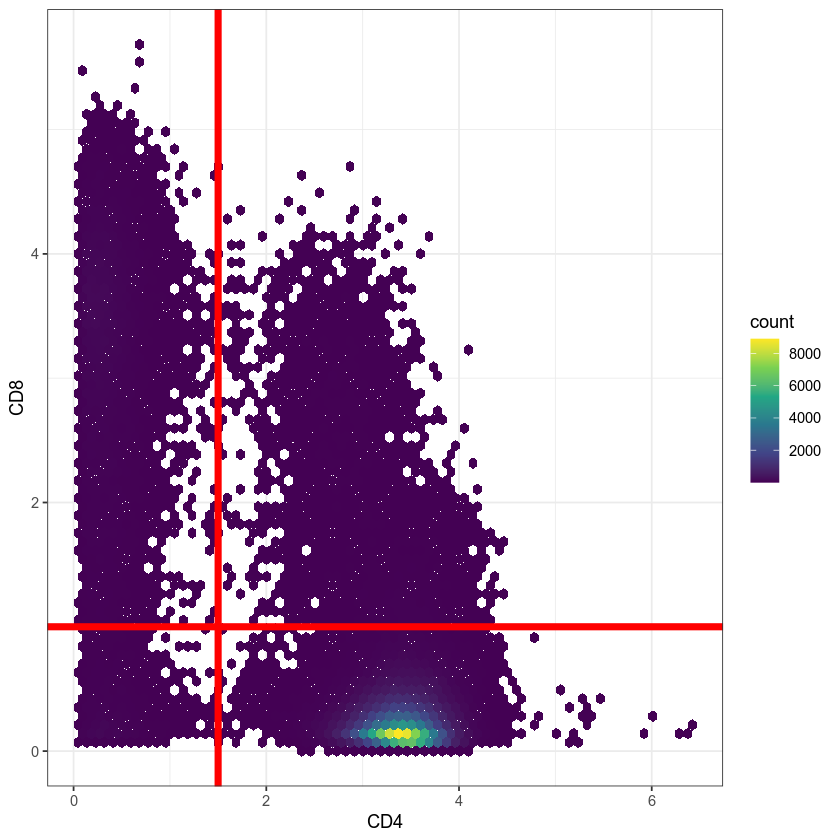

In [577]:
# Find low vs high CD4
ggplot(to_plot[some_expr,], aes(x=CD4, y=CD8) ) +
  geom_hex(bins = 70) +
  scale_fill_continuous(type = "viridis") +
  theme_bw()+
    geom_vline(xintercept=1.5, color = "red", size=2)+
    geom_hline(yintercept=1, color = "red", size=2)

In [578]:
# Set gating thresholds for CD4+ and CD8+ cell populations
CD4_low = CD4<1.5
CD4_high = CD4>=1.5
CD8_low = CD8<1
CD8_high = CD8>=1

# Add CD4 and CD8 assignments to current data object
curr_res$CD4 = CD4_high&CD8_low
curr_res$CD8 = CD4_low&CD8_high

In [596]:
# What fractions of our total T cell dataset belong to each CD4/CD8 categorization?
fractions = matrix(c(sum(CD4_low&CD8_high)/length(CD4), sum(CD4_low&CD8_low)/length(CD4),
         sum(CD4_high&CD8_high)/length(CD4), sum(CD4_high&CD8_low)/length(CD4)),nrow = 2)
round(fractions,3)*100

4.5,1.3
1.2,93.0


### Marker Gene Distributions for Reference

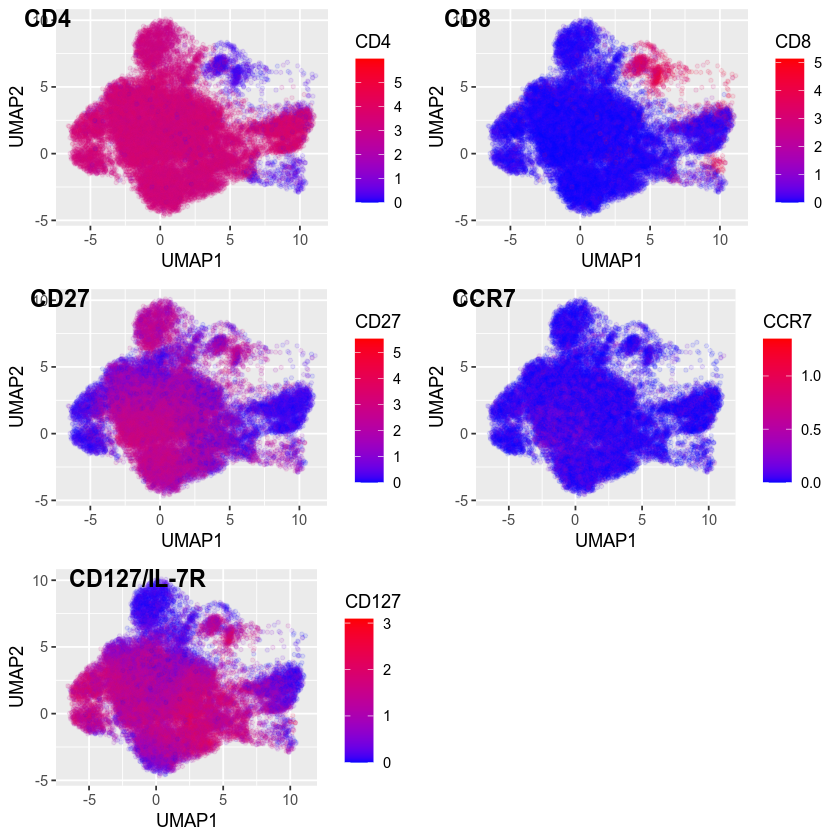

In [651]:
# Organize data to plot
ix = sample(c(1:ncol(prot_mat)), 30000, replace=FALSE) # Downsample
plot_df = data.frame("UMAP1" = curr_res$UMAP1[ix], "UMAP2"= curr_res$UMAP2[ix],
                     "CD8" = prot_mat[grep("CD8a", rownames(prot_mat)),ix], 
                     "CD4"= prot_mat[grep("CD4.1", rownames(prot_mat)),ix], 
                     "CD27" = prot_mat[grep("CD27.1", rownames(prot_mat)),ix],
                    "CCR7" = prot_mat[grep("CCR7", rownames(prot_mat)),ix],
                    "CD127" = prot_mat[grep("CD127/IL-7R", rownames(prot_mat)),ix])

# CD8
CD8_plot<-ggplot(plot_df, aes(x=UMAP1, y=UMAP2, color=CD8)) + 
    geom_point(alpha = 0.1, shape = 20)+
    scale_color_gradient(low="blue", high="red")

# CD4
CD4_plot<-ggplot(plot_df, aes(x=UMAP1, y=UMAP2, color=CD4)) + 
    geom_point(alpha = 0.1, shape = 20)+
    scale_color_gradient(low="blue", high="red")

# CD27
CD27_plot<-ggplot(plot_df, aes(x=UMAP1, y=UMAP2, color=CD27)) + 
    geom_point(alpha = 0.1, shape = 20)+
    scale_color_gradient(low="blue", high="red")

# CCR7
CCR7_plot<-ggplot(plot_df, aes(x=UMAP1, y=UMAP2, color=CCR7)) + 
    geom_point(alpha = 0.1, shape = 20)+
    scale_color_gradient(low="blue", high="red")

# CD127
CD127_plot<-ggplot(plot_df, aes(x=UMAP1, y=UMAP2, color=CD127)) + 
    geom_point(alpha = 0.1, shape = 20)+
    scale_color_gradient(low="blue", high="red")

figure <- ggarrange(CD4_plot, CD8_plot, CD27_plot, CCR7_plot, CD127_plot,
                    labels = c("CD4", "CD8", "CD27", "CCR7", "CD127/IL-7R"),
                    ncol = 2, nrow = 3)
figure